In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import h5py as h5
import numpy as np
import healpy as hp

# load a map & create shear field

In [9]:
# Let's load the convergence map.
path = '/global/cscratch1/sd/mgatti/Mass_Mapping/map_minsu.npy'
map_2048 = np.load(path,allow_pickle=True)

# downgrade the map 
nside_out = 256
map_256 = hp.alm2map(hp.map2alm(map_2048,lmax = 2048*2),nside = nside_out)


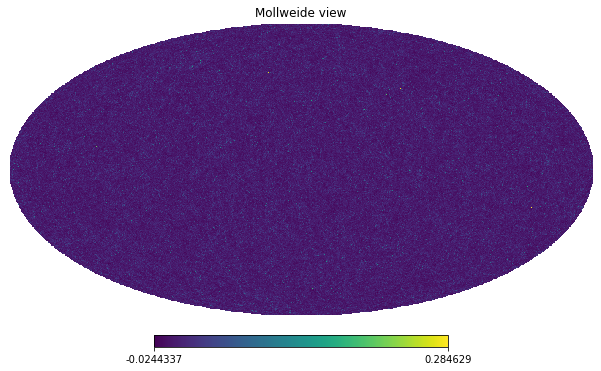

In [41]:
# visualise the map
hp.mollview(map_256)

Now we have a healpy map to play wth. This is a convergence field map; we would like to convert it to the related components (two!) of the shear field, since the shear field is the real observable. We can do this through KS inversion (https://arxiv.org/pdf/1708.01535.pdf, eq.9), which allows to relate the shear field to the convergence field easily in harmonc space.

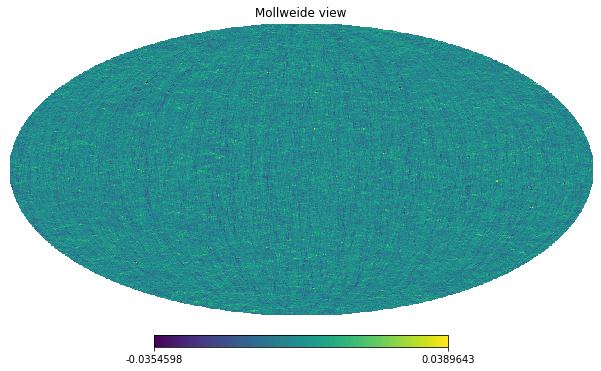

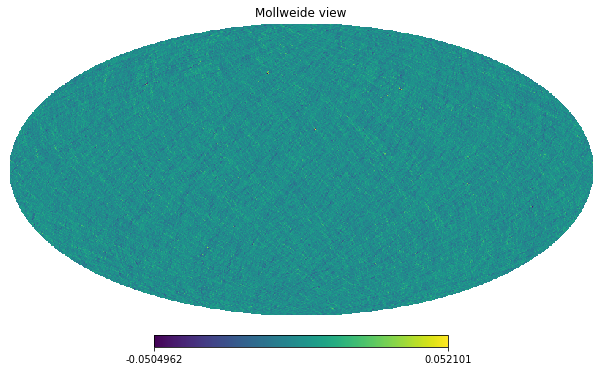

In [42]:
from Moments_analysis import gk_inv
#gk_inv(K,KB,nside,lmax)
g1_map,g2_map = gk_inv(map_256,map_256*0.,nside_out,nside_out*2)
hp.mollview(g1_map)
hp.mollview(g2_map)

Let's now add some noise. The maps you have above are map of the shear field, whereas normally we have 'shape noise' (each galaxy has its own ellpticity and orientation). You have different ways of adding noise to a simulated shear maps.

 average number of galaxies per pixel:  260


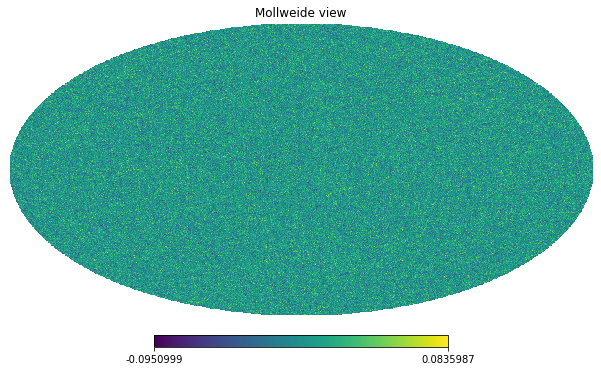

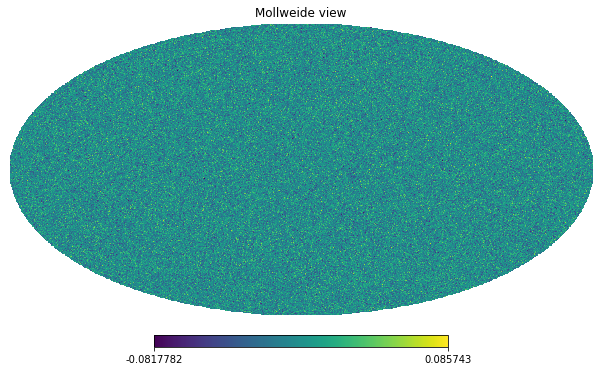

In [112]:
from Moments_analysis import apply_random_rotation,addSourceEllipticity,convert_to_pix_coord
# fast way.

std_e = 0.28 # typical values for DES Y3 between 0.26-0.33, depending on the tomographic bin.
n_density = 5.51/4. # gal/arcmin^2; 5.51 is the full des y3 catalog,  divide by 4 because we have 4 tomographc bins.
n_gal_per_pixel = np.int(n_density*hp.nside2resol(nside_out, arcmin = True)**2)
print (' average number of galaxies per pixel: ',n_gal_per_pixel)

# we always assume noise to be gaussian, and the two components to be uncorrelated; the noise in each pxel scales as 1/sqrt(n_gal)
e1_noise_map = np.random.normal(0,std_e/np.sqrt(n_gal_per_pixel),len(g1_map))
e2_noise_map = np.random.normal(0,std_e/np.sqrt(n_gal_per_pixel),len(g2_map))

# add noise
e1_map,e2_map = addSourceEllipticity({'shear1':g1_map,'shear2':g2_map},{'e1':e1_noise_map,'e2':e2_noise_map},es_colnames=("e1","e2"))


hp.mollview(e1_map)
hp.mollview(e2_map)

In [ ]:
# slightly more accurate way. We can use the fiducial DES Y3 catalog, and use realistic noise and galaxy distribution.

In [ ]:
import pickle
def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        mute =  pickle.load(f)
        f.close()
    return mute

mcal_catalog = load_obj('/project/projectdirs/des/mass_maps/Maps_final/data_catalogs_weighted')
tomo_bin = 2 #ths is the 3rd WL bin


In [187]:

# copy ra,dec,e1,e2 from the real catalog.
dec1 = mcal_catalog[i]['dec']
ra1 = mcal_catalog[i]['ra']
e1_catalog = mcal_catalog[i]['e1']
e2_catalog = mcal_catalog[i]['e2']
w = mcal_catalog[i]['w']


# get the healpix pixel from the catalog's coordinates.
pix = convert_to_pix_coord(ra1,dec1, nside=nside_out)

# apply a random rotation to the des catalog measured shapes. if you do this, you 'cancel' the shear signal in the catalog,
#and you're left with 'shape noise'
e1_noise_catalog, e2_noise_catalog = apply_random_rotation(e1_catalog,e2_catalog)

# get the value of the smulated shear map in the pixels where we have des y3 galaxies
g1_simulated_catalog = g1[pix]
g2_simulated_catalog = g2[pix]

e1_simulated_catalog,e2_simulated_catalog = addSourceEllipticity({'shear1':g1_simulated_catalog,'shear2':g2_simulated_catalog},{'e1':e1_noise_catalog,'e2':e2_noise_catalog},es_colnames=("e1","e2"))
    
        
# create a map of simulated noise & simulated ellipticities:
n_map = np.zeros(hp.nside2npix(nside_out))
e1_map_v2 = np.zeros(hp.nside2npix(nside_out))
e2_map_v2 = np.zeros(hp.nside2npix(nside_out))
e1_noise_map_v2 = np.zeros(hp.nside2npix(nside_out))
e2_noise_map_v2 = np.zeros(hp.nside2npix(nside_out))

unique_pix, idx, idx_rep = np.unique(pix, return_index=True, return_inverse=True)
n_map[unique_pix] += np.bincount(idx_rep, weights=w)
e1_noise_map_v2[unique_pix] += np.bincount(idx_rep, weights=w*e1_noise_catalog)
e2_noise_map_v2[unique_pix] += np.bincount(idx_rep, weights=w*e2_noise_catalog)
e1_map_v2[unique_pix] += np.bincount(idx_rep, weights=w*e1_simulated_catalog)
e2_map_v2[unique_pix] += np.bincount(idx_rep, weights=w*e2_simulated_catalog)

mask = n_map!=0.
e1_noise_map_v2[mask] /=n_map[mask]
e2_noise_map_v2[mask] /=n_map[mask]
e1_map_v2[mask] /=n_map[mask]
e2_map_v2[mask] /=n_map[mask]

hp.mollview(n_map)





# create a map of of the data-
n_data_map = np.zeros(hp.nside2npix(nside_out))
e1_data_map = np.zeros(hp.nside2npix(nside_out))
e2_data_map = np.zeros(hp.nside2npix(nside_out))
e1_data_noise_map = np.zeros(hp.nside2npix(nside_out))
e2_data_noise_map = np.zeros(hp.nside2npix(nside_out))

unique_pix, idx, idx_rep = np.unique(pix, return_index=True, return_inverse=True)
n_data_map[unique_pix] += np.bincount(idx_rep, weights=w)
e1_data_map[unique_pix] += np.bincount(idx_rep, weights=w* mcal_catalog[i]['e1'])
e2_data_map[unique_pix] += np.bincount(idx_rep, weights=w* mcal_catalog[i]['e2'])
e1_data_noise_map[unique_pix] += np.bincount(idx_rep, weights=w* mcal_catalog[i]['e1r'])
e2_data_noise_map[unique_pix] += np.bincount(idx_rep, weights=w* mcal_catalog[i]['e2r'])

mask = n_data_map!=0.
e1_data_map[mask] /=n_data_map[mask]
e2_data_map[mask] /=n_data_map[mask]
e1_data_noise_map[mask] /=n_data_map[mask]
e2_data_noise_map[mask] /=n_data_map[mask]


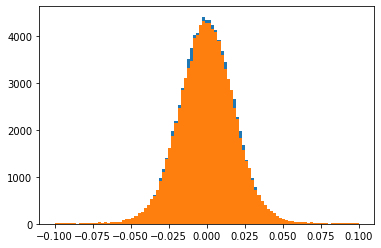

In [137]:
# compare the noise maps
_ = plt.hist(e1_noise_map[mask], bins = np.linspace(-0.1,0.1,100))
_ = plt.hist(e1_noise_map_v2[mask], bins = np.linspace(-0.1,0.1,100))

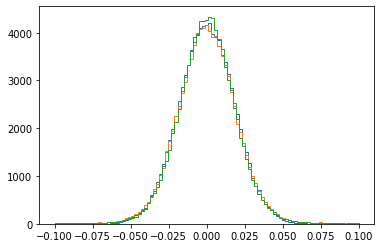

In [141]:
# compare the ellepticities maps
_ = plt.hist(e1_map[mask], bins = np.linspace(-0.1,0.1,100),histtype='step')
_ = plt.hist(e1_map_v2[mask], bins = np.linspace(-0.1,0.1,100),histtype='step')
_ = plt.hist(e1_data_map[mask], bins = np.linspace(-0.1,0.1,100),histtype='step')



# measure moments

let's use the moments repo to measure second and third moments of the simulated map. When you compute moments, you also want to compute the moments of the noise, and the moments between the noise and the measurement. This is because

<k_meas^2> = <(k_noiseless+k_noise)^2> = <k_noiseless^2>+2*<k_noiseless * k_noise> +<k_noise^2>
(similar for third order).
What you really want to get is <k_noiseless^2>.Usually <k_noiseless * k_noise> vanishes; you just need to estmate <k_noise^2> and subtract it from  <k_meas^2>.
See eq. 15-16 https://arxiv.org/pdf/1911.05568.pdf

The code does the noise subtracton automatically for second moments. For third moments, mixed moments should vansh.

THIS MEASUREMENTS DON'T COME WITH A COVARIANCE! the covariance must be estimated from simulations.


In [147]:
#let's compute the moments of the simulated map.
from Moments_analysis import moments_map
# apply des y3 mask (optional)
e1_map[~mask] = 0.
e2_map[~mask] = 0.
e1_noise_map[~mask] = 0.
e2_noise_map[~mask] = 0.
g1_map[~mask] = 0.
g2_map[~mask] = 0.

conf = dict()
conf['smoothing_scales'] = np.array([21.0,33.6,54.,86.]) # arcmin
conf['nside'] = 256
conf['lmax'] = conf['nside']*2
conf['verbose'] = False
conf['output_folder'] = '/global/cscratch1/sd/mgatti/Mass_Mapping/moments/simulated_moments/'

mcal_moments = moments_map(conf)

# this add the maps

mcal_moments.add_map(e1_map, field_label = 'e1', tomo_bin = 0)
mcal_moments.add_map(e2_map, field_label = 'e2', tomo_bin = 0)

mcal_moments.add_map(e1_noise_map, field_label = 'e1r', tomo_bin = 0)
mcal_moments.add_map(e2_noise_map, field_label = 'e2r', tomo_bin = 0)

# this can't be done in data! it's the noiseless shear feld map..we don't have it :)
mcal_moments.add_map(g1_map, field_label = 'g1', tomo_bin = 0)
mcal_moments.add_map(g2_map, field_label = 'g2', tomo_bin = 0)
    

# this does the following:
# 1) transform e1,e2 to harmonc space
# 2) applies a filter function
# 3) convert to convergence
# 4) get back to 'real space' and gives you E/B maps.
mcal_moments.transform_and_smooth('convergence_noiseless','g1','g2', shear = True, tomo_bins = [0],  overwrite = True , skip_conversion_toalm = False)                 
mcal_moments.transform_and_smooth('convergence','e1','e2', shear = True, tomo_bins = [0],  overwrite = True , skip_conversion_toalm = False)                 
mcal_moments.transform_and_smooth('noise','e1r','e2r', shear = True, tomo_bins = [0], overwrite = True , skip_conversion_toalm = False)                 



# compute moments***
mcal_moments.compute_moments( label_moments='kE_kE_', field_label1 ='convergence_noiseless_kE',  tomo_bins1 = [0])
mcal_moments.compute_moments( label_moments='kB_kB_', field_label1 ='convergence_noiseless_kB',  tomo_bins1 = [0])
mcal_moments.compute_moments( label_moments='kEkE', field_label1 ='convergence_kE', denoise1 = 'noise_kE',  tomo_bins1 = [0])
mcal_moments.compute_moments( label_moments='kBkB', field_label1 ='convergence_kB', denoise1 = 'noise_kB',  tomo_bins1 = [0])

# k NN needs to be subtracted for corrections to the third moments ***
mcal_moments.compute_moments( label_moments='kEkN', field_label1 ='convergence_kE', field_label2 = 'noise_kE', denoise1 = 'noise_kE',  tomo_bins1 = [0])
mcal_moments.compute_moments( label_moments='kNkE', field_label2 ='convergence_kE', field_label1 = 'noise_kE', denoise1 = 'noise_kE',  tomo_bins1 = [0])
mcal_moments.compute_moments( label_moments='kNkN', field_label2 ='noise_kE', field_label1 = 'noise_kE',  tomo_bins1 = [0])


mcal_moments.compute_moments( label_moments='kBkN', field_label1 ='convergence_kB', field_label2 = 'noise_kB', denoise1 = 'noise_kE',  tomo_bins1 = [0])
mcal_moments.compute_moments( label_moments='kNkB', field_label2 ='convergence_kB', field_label1 = 'noise_kB', denoise1 = 'noise_kE',  tomo_bins1 = [0])
mcal_moments.compute_moments( label_moments='kNBkNB', field_label2 ='noise_kB', field_label1 = 'noise_kB',  tomo_bins1 = [0])



In [149]:
# all the moments combinations:
mcal_moments.moments.keys()

dict_keys(['kE_kE_', 'kB_kB_', 'kEkE', 'kBkB', 'kEkN', 'kNkE', 'kNkN', 'kBkN', 'kNkB', 'kNBkNB'])

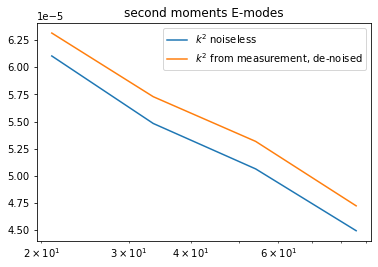

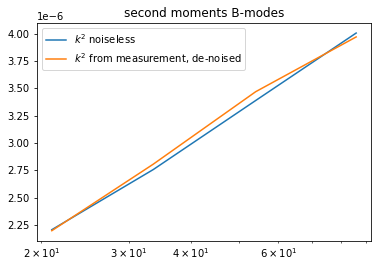

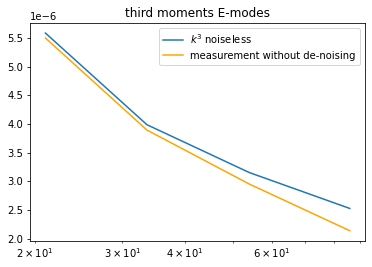

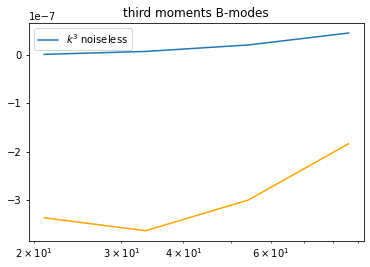

In [178]:


x = conf['smoothing_scales']
plt.title('second moments E-modes')
plt.plot(x,mcal_moments.moments['kE_kE_']['0_0']*x,label = r'$k^2$ noiseless')
plt.plot(x,mcal_moments.moments['kEkE']['0_0']*x,label = r'$k^2$ from measurement, de-noised')
plt.xscale('log')
plt.legend()
plt.show()

plt.title('second moments B-modes') # this B-modes are only due to mask effects!!
plt.plot(x,mcal_moments.moments['kB_kB_']['0_0']*x,label = r'$k^2$ noiseless')
plt.plot(x,mcal_moments.moments['kBkB']['0_0']*x,label = r'$k^2$ from measurement, de-noised')
plt.xscale('log')
plt.legend()
plt.show()


'''
For third moments, there's no de-nosing involved. If the noise is Gaussian, all the  cross moments involving the nose should vansh. 
'''

plt.title('third moments E-modes')
plt.plot(x,mcal_moments.moments['kE_kE_']['0_0_0']*x*x,label = r'$k^3$ noiseless')
plt.plot(x,mcal_moments.moments['kEkE']['0_0_0']*x*x,color='orange',label = 'measurement without de-noising')
plt.xscale('log')
plt.legend()
plt.show()




plt.title('third moments B-modes')


plt.plot(x,mcal_moments.moments['kB_kB_']['0_0_0']*x*x,label = r'$k^3$ noiseless')
plt.plot(x,mcal_moments.moments['kBkB']['0_0_0']*x*x,color='orange')
plt.legend()
plt.xscale('log')


